In [1]:
import os
import gc
import sys
import joblib
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime
from argparse import Namespace
from collections import defaultdict
from scipy.signal import find_peaks

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, GroupKFold, train_test_split, KFold

import lightgbm as lgb
from lightgbm import LGBMRegressor

import matplotlib.style as style
style.use('fivethirtyeight') 

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [2]:
args = Namespace(
    train=True,
    optimize=False,
    train_l2=False,
    inference=False,
    seed=21,
    folds=5,
    workers=4,
    min_time_id=None, 
    holdout=False,
    cv_method="single",
    num_bins=16,
    holdout_size=100,
    outlier_threshold=0.005,
    trading_days_per_year=250,   # chinese stock market trading days per year (roughly)
    add_investment_id_model=False,
    data_path=Path(""),
    just_eda=True,
)
seed_everything(args.seed)

assert args.cv_method in {"single", "kfold", "group", "stratified", "time", "group_time", "time_range"}, "unknown cv method"
assert args.data_path.exists(), "data_path not exists"

In [3]:
%%time
train = pd.read_parquet(args.data_path.joinpath("train_low_mem.parquet"))
# assert train.isnull().any().sum() == 0, "null exists."
# assert train.row_id.str.extract(r"(?P<time_id>\d+)_(?P<investment_id>\d+)").astype(train.time_id.dtype).equals(train[["time_id", "investment_id"]]), "row_id!=time_id_investment_id"
# assert train.time_id.is_monotonic_increasing, "time_id not monotonic increasing"

CPU times: user 2.95 s, sys: 788 ms, total: 3.74 s
Wall time: 3.74 s


# Features EDA + processing

### Possible outliers

0.10802400507032894

-0.22408594757318495

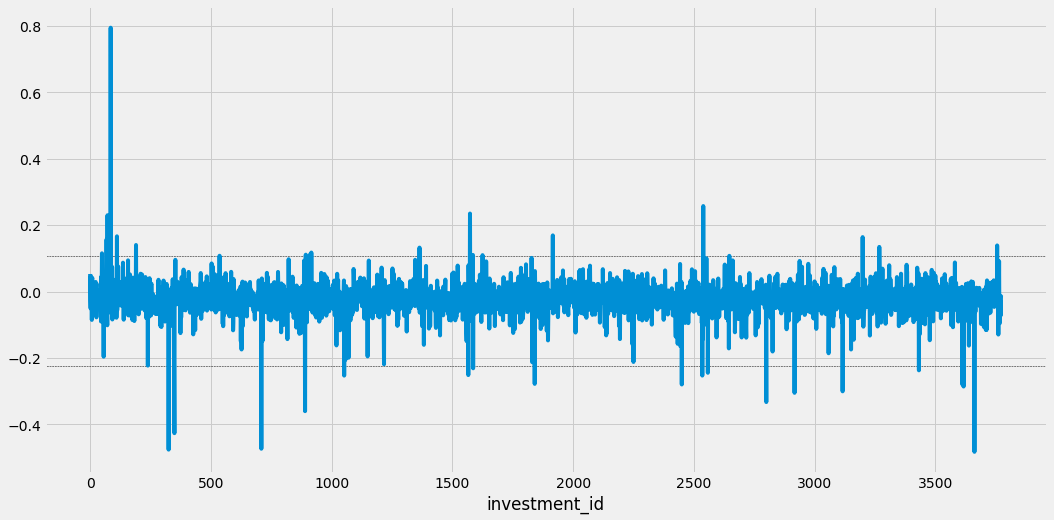

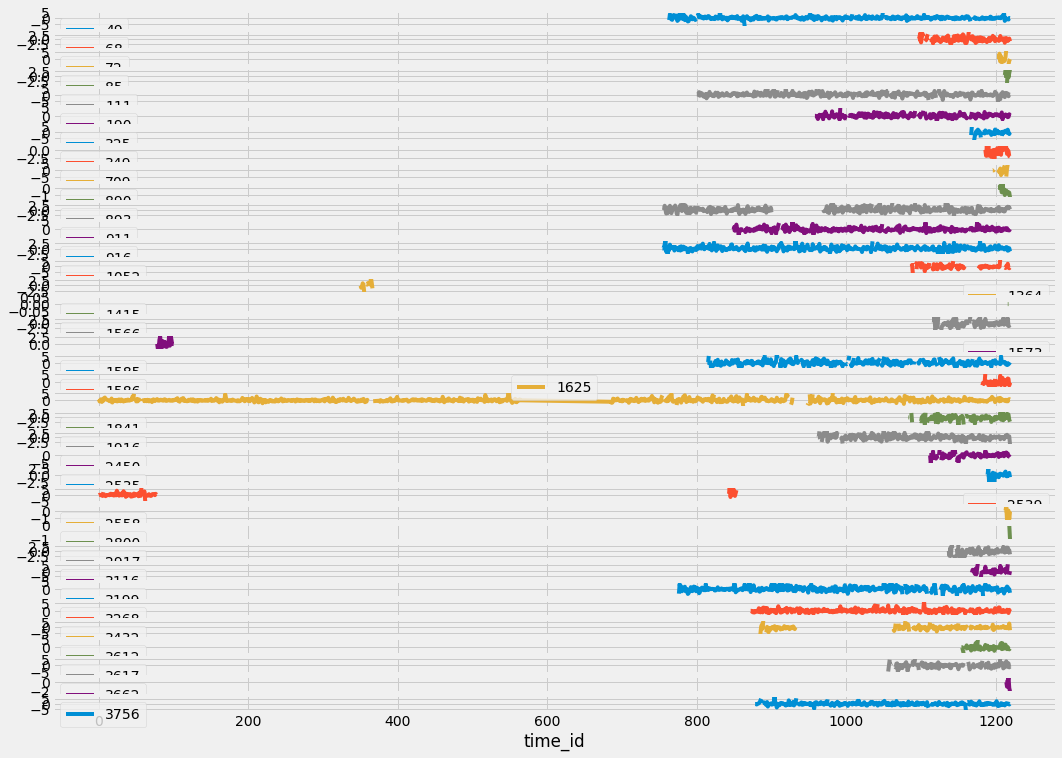

In [4]:
df = train[["investment_id", "target"]].groupby("investment_id").target.mean()
upper_bound, lower_bound = df.quantile([1-args.outlier_threshold, args.outlier_threshold])
display(upper_bound, lower_bound)
ax = df.plot(figsize=(16, 8))
ax.axhspan(lower_bound, upper_bound, fill=False, linestyle="--", color="k")
plt.show()

outlier_investments = df.loc[(df>upper_bound)|(df<lower_bound)|(df==0)].index
_=pd.pivot(
    train.loc[train.investment_id.isin(outlier_investments), ["investment_id", "time_id", "target"]],
    index='time_id', columns='investment_id', values='target'
).plot(figsize=(16,12), subplots=True, sharex=True)

# Drop indexes with feature outliers: [notebook](https://www.kaggle.com/junjitakeshima/ubiquant-simple-lgbm-removing-outliers-en-jp)

In [5]:
outlier_list = []
outlier_col = []

for col in (f"f_{i}" for i in range(300)):
    _mean, _std = train[col].mean(), train[col].std()
    
    temp_df = train.loc[(train[col] > _mean + _std * 70) | (train[col] < _mean - _std * 70)]
    temp2_df = train.loc[(train[col] > _mean + _std * 35) | (train[col] < _mean - _std * 35)]
    if len(temp_df) >0 : 
        outliers = temp_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp_df))
    elif len(temp2_df)>0 and len(temp2_df) <6 :
        outliers = temp2_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp2_df))

outlier_list = list(set(outlier_list))
train.drop(train.index[outlier_list], inplace=True)
print(len(outlier_col), len(outlier_list), train.shape)

f_4 6
f_10 1
f_12 1
f_13 1
f_37 3
f_49 1
f_55 2
f_62 1
f_77 5
f_78 1
f_87 3
f_99 4
f_104 1
f_108 5
f_115 14
f_117 16
f_118 2
f_122 2
f_124 17
f_127 16
f_128 5
f_136 2
f_137 1
f_145 2
f_149 2
f_155 2
f_162 1
f_165 1
f_172 2
f_174 1
f_175 30
f_179 4
f_193 3
f_196 1
f_197 1
f_200 37
f_209 5
f_214 1
f_215 1
f_219 1
f_233 3
f_249 1
f_250 4
f_265 1
f_277 1
f_280 3
f_289 6
f_295 1
48 174 (3141236, 304)


### Drop outliers from train

In [6]:
if args.min_time_id is not None:
    train = train.query("time_id>=@args.min_time_id").reset_index(drop=True)
    gc.collect()
    
train=train.loc[~train.investment_id.isin(outlier_investments)].reset_index(drop=True)
train.shape

(3134707, 304)

### Strange behaviour of some features according to time id

### f_1

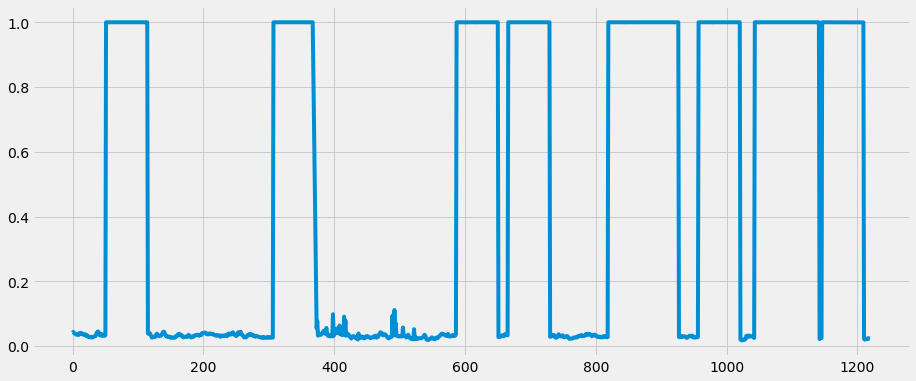

In [7]:
def get_unique_total_values_ratio(df, feature, plot=False, return_result=False):
    df_date_group = df.groupby('time_id').agg({feature: [lambda x: len(x.unique()), 'count']})
    df_date_group.columns.set_levels(['len_unique','count'], level=1,inplace=True)
    df_date_group['unique_count_ratio'] = df_date_group[feature]['len_unique']/df_date_group[feature]['count']
    df_date_group['num_or_cat'] = df_date_group['unique_count_ratio'].apply(lambda x: 1 if x > 0.5 else 0)
    if plot:
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(111)
        plt.plot(df_date_group.index, df_date_group['unique_count_ratio'] , label="Number of unique investments")
    if return_result:
        return df_date_group['num_or_cat']

get_unique_total_values_ratio(train, 'f_1', plot=True)

### f_6

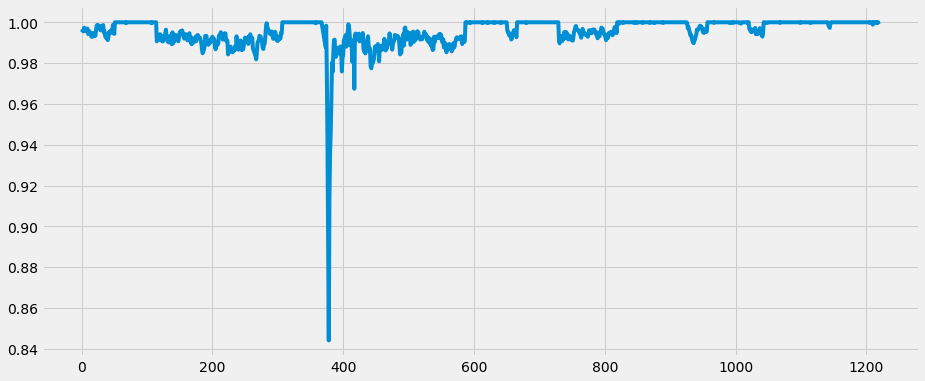

In [8]:
get_unique_total_values_ratio(train, 'f_6', plot=True)

### f_7

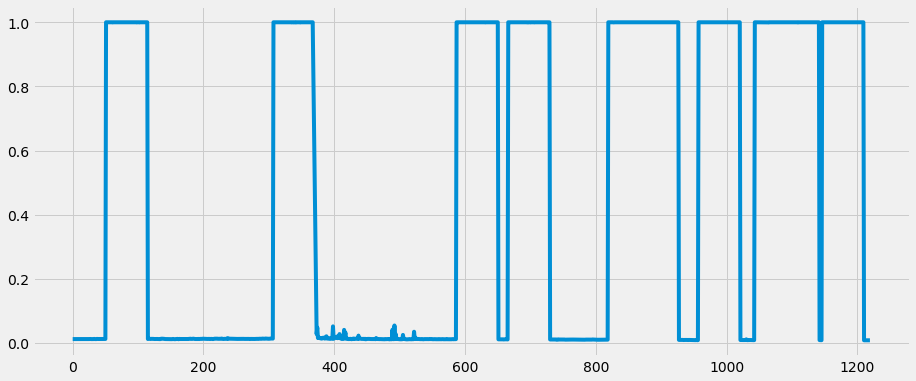

In [9]:
num_or_cat = get_unique_total_values_ratio(train, 'f_7', plot=True, return_result=True)

### Add time_id features

In [10]:
time_id_df = (
    train[["investment_id", "time_id"]]
    .groupby("investment_id")
    .agg(["min", "max", "count", np.ptp])
    .assign(
        time_span=lambda x: x.time_id.ptp,
        time_count=lambda x: x.time_id["count"]
    )
    .drop(columns="ptp", level=1)
    .reset_index()
)
time_id_df.head(6)

investment_id time_id             time_span time_count
                    min   max count                     
0             0     757  1219   461       462        461
1             1       0  1219  1108      1219       1108
2             2       0  1219  1003      1219       1003
3             3      27  1219  1073      1192       1073
4             4     885  1219   316       334        316
5             6       0  1219  1082      1219       1082

### Merge time features with train dataframe

9365

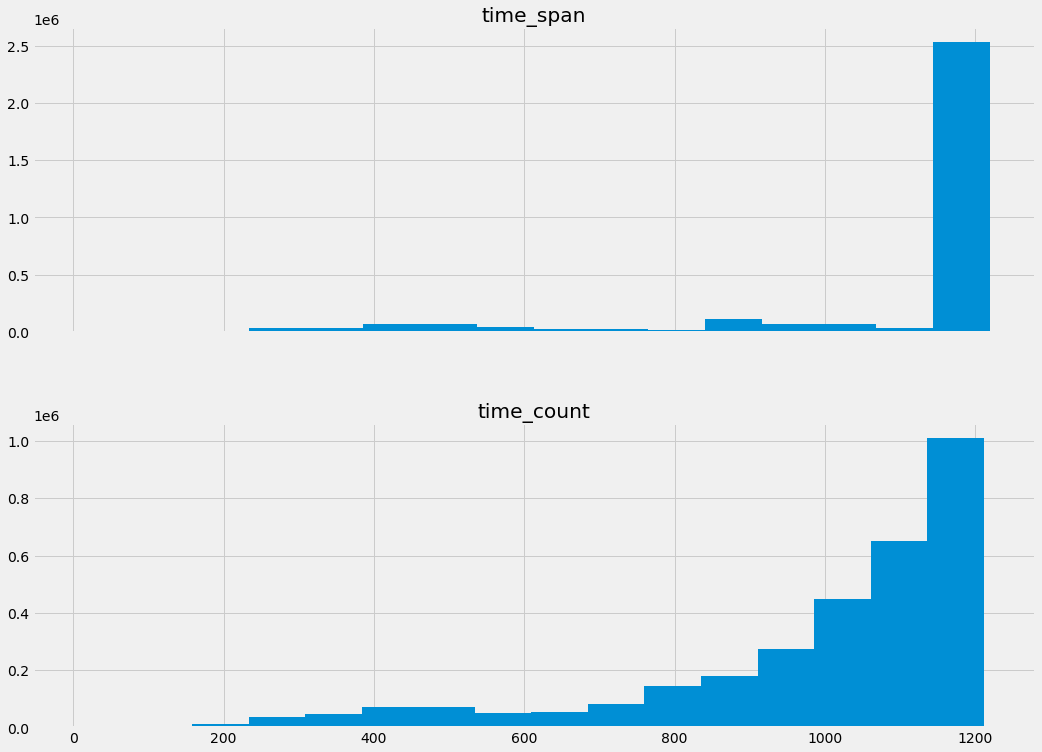

In [11]:
train = train.merge(time_id_df.drop(columns="time_id", level=0).droplevel(level=1, axis=1), on="investment_id", how='left')
train[["time_span", "time_count"]].hist(bins=args.num_bins, figsize=(16,12), sharex=True, layout=(2,1))
max_time_span=time_id_df.time_id["max"].max()
outlier_investments = time_id_df.loc[time_id_df.time_id["count"]<32, "investment_id"].to_list()
del time_id_df
gc.collect()

### Add cluster feature

In [12]:
inv_id_to_cluster = pd.read_pickle('clustered_inv_index.pkl')

train = train.merge(inv_id_to_cluster, how='left', on='investment_id')
train.cluster.fillna(0, inplace=True)

### Add time group feature

In [13]:
train.loc[(train['time_id'] < 910), 'group'] = 0
train.loc[(train['time_id'] >= 910) & (train['time_id'] < 970), 'group'] = 1
train.loc[(train['time_id'] >= 970) & (train['time_id'] < 1030), 'group'] = 2
train.loc[(train['time_id'] >= 1030) & (train['time_id'] < 1090), 'group'] = 3
train.loc[(train['time_id'] >= 1090) & (train['time_id'] < 1150), 'group'] = 4
train.loc[(train['time_id'] >= 1150), 'group'] = 5
train['group'] = train['group'].astype(np.int16)

### Add feature that shows if some features are categorical or numerical for the current time_id

In [14]:
# add numerical/categorical flag
train = train.merge(num_or_cat, how='left', on='time_id')

### Some features are not stationary. Let's make a rank transformation by time_id to make them stationary

In [15]:
train['f_74']  = train[['time_id', 'f_74']].groupby('time_id').rank(pct=True)
train['f_142']  = train[['time_id', 'f_142']].groupby('time_id').rank(pct=True)
train['f_63']  = train[['time_id', 'f_63']].groupby('time_id').rank(pct=True)

### Add total number of investment ids in the current time slot

In [16]:
# investment_id_df = (
#     train[["investment_id", "time_id"]]
#     .groupby("time_id")
#     .agg("count")
#     .rename({"investment_id": "number_of_inv_ids"}, axis=1)
#     .reset_index()
# )
# investment_id_df.head()

# train = train.merge(investment_id_df, how='left', on='time_id')

### Add lags

In [17]:
features_with_lags = ['f_0', 'f_3', 'f_8', 'f_13', 'f_32', 'f_41', 'f_59', 
                      'f_61', 'f_62', 'f_63', 'f_67', 'f_68', 'f_71', 
                      'f_73', 'f_74', 'f_78', 'f_98', 'f_99', 'f_200', 
                      'f_208', 'f_210', 'f_212', 'f_213', 'f_216', 'f_219', 
                      'f_22', 'f_225', 'f_229', 'f_231', 'f_240', 'f_241', 
                      'f_244', 'f_246', 'f_247', 'f_248', 'f_249', 'f_25', 
                      'f_251', 'f_255', 'f_259', 'f_263', 'f_267', 'f_268', 
                      'f_269', 'f_271', 'f_272', 'f_275', 'f_278', 'f_286', 
                      'f_287', 'f_289', 'f_291', 'f_293']

train_lag_1 = train[['time_id', 'investment_id'] + features_with_lags].copy()
train_lag_1.columns = ['time_id', 'investment_id'] + [f + '_lag_1' for f in train_lag_1.columns[2:]]
train_lag_1.time_id += 1

train = train.merge(train_lag_1, how='left', on=['time_id', 'investment_id'])

num_features = [c for c in train.columns if c.startswith('f_')]
num_features += [f + '_lag_1' for f in features_with_lags]
train.fillna(train.target.mean(), inplace=True)
# train = train.query('time_id > 0')

del train_lag_1
gc.collect()

7476

### Make combinations for some features and drop not necessary features.

In [18]:
cat_features = ['num_or_cat', 'cluster']
features = num_features + cat_features + ['time_id']

# make feature combinations
combination_features = ["f_231-f_250", "f_118-f_280", "f_155-f_297", "f_25-f_237", "f_179-f_265", "f_119-f_270", "f_71-f_197", "f_21-f_65"]
for f in combination_features:
    f1, f2 = f.split("-")
    train[f] = train[f1] + train[f2]
features += combination_features

# drop unnecessary features
to_drop = ["f_148", "f_72", "f_49", "f_205", "f_228", "f_97", "f_262", "f_258"]#, "f_72_lag_1", "f_49_lag_1", "f_205_lag_1", "f_228_lag_1", "f_97_lag_1", "f_262_lag_1", "f_258_lag_1"]
features = list(sorted(set(features).difference(set(to_drop))))
train = train.drop(columns=["row_id"] + to_drop)

features_backup = features.copy()
gc.collect()

29

### Reduce memory usage.

In [19]:
%%time

train = reduce_mem_usage(train)
train[["investment_id", "time_id"]] = train[["investment_id", "time_id"]].astype(np.uint16)
gc.collect()

Memory usage of dataframe is 4400.53 MB
Memory usage after optimization is: 2173.36 MB
Decreased by 50.6%
CPU times: user 1min 13s, sys: 47.5 s, total: 2min 1s
Wall time: 2min 1s


0

### Standard scale numerical features

In [20]:
%%time

rscaler = StandardScaler()
features_to_scale = [c for c in train.columns if c.startswith('f_')]
train[features_to_scale] = rscaler.fit_transform(train[features_to_scale])

CPU times: user 1min 2s, sys: 837 ms, total: 1min 3s
Wall time: 1min 3s


# Train

### Set scoring and training functions

In [21]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# TODO: replace with feval_pearsonr
def feval_rmse(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'rmse', rmse(y_true, y_pred), False

# https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302480
def feval_pearsonr(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'pearsonr', pearsonr(y_true, y_pred)[0], True

# https://www.kaggle.com/gogo827jz/jane-street-supervised-autoencoder-mlp?scriptVersionId=73762661
# weighted average as per Donate et al.'s formula
# https://doi.org/10.1016/j.neucom.2012.02.053
# [0.0625, 0.0625, 0.125, 0.25, 0.5] for 5 fold
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return np.average(a, weights = w)

def run(info):    
    # hyperparams from: https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization
    params = {
        'learning_rate':0.05,
        "objective": "regression",
        "metric": "rmse",
        'boosting_type': "gbdt",
        'verbosity': -1,
        'n_jobs': -1, 
        'seed': args.seed,
#         'lambda_l1': 0.03627602394442367, 
#         'lambda_l2': 0.43523855951142926, 
#         'num_leaves': 114, 
#         'feature_fraction': 0.9505625064462319, 
#         'bagging_fraction': 0.9785558707339647, 
#         'bagging_freq': 7, 
#         'max_depth': -1, 
#         'max_bin': 501, 
#         'min_data_in_leaf': 374,
        'n_estimators': 1000, 
    }
    
    y = train['target']
    train['preds'] = -1000
    scores = defaultdict(list)
    features_importance= []
    
    def run_single_fold(fold, trn_ind, val_ind):
        train_dataset = lgb.Dataset(train.loc[trn_ind, features], y.loc[trn_ind], categorical_feature=cat_features)
        valid_dataset = lgb.Dataset(train.loc[val_ind, features], y.loc[val_ind], categorical_feature=cat_features)
        model = lgb.train(
            params,
            train_set = train_dataset, 
            valid_sets = [train_dataset, valid_dataset], 
            verbose_eval=50,
            early_stopping_rounds=50,
            feval = feval_pearsonr
        )
        joblib.dump(model, f'lgbm_seed{args.seed}_{fold}_{info}.pkl')
        preds = model.predict(train.loc[val_ind, features])
        train.loc[val_ind, "preds"] = preds
        scores["rmse"].append(rmse(y.loc[val_ind], preds))
        scores["pearsonr"].append(pearsonr(y.loc[val_ind], preds)[0])
        fold_importance_df= pd.DataFrame({'feature': features, 'importance': model.feature_importance(), 'fold': fold})
        features_importance.append(fold_importance_df)
        del train_dataset, valid_dataset
        gc.collect()
        
    time_thresh = round(train.time_id.max() * 0.9)
    trn_ind, val_ind = train.time_id < time_thresh, train.time_id >= time_thresh
    print(f"train length: {trn_ind.sum()}, valid length: {val_ind.sum()}")
    run_single_fold("single", trn_ind, val_ind)
        
    print(f"lgbm {info} mean rmse: {np.mean(scores['rmse'])}, mean pearsonr: {np.mean(scores['pearsonr'])}")
    if "time" in args.cv_method:
        print(f"lgbm {info} {args.folds} folds weighted mean rmse: {weighted_average(scores['rmse'])}, weighted mean pearsonr: {weighted_average(scores['pearsonr'])}")
    train.filter(regex=r"^(?!f_).*").to_csv(f"preds_{info}.csv", index=False)
    return pd.concat(features_importance, axis=0), scores

### Train with deafault params

train length: 2730227, valid length: 404480
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.913258	training's pearsonr: 0.145392	valid_1's rmse: 0.892635	valid_1's pearsonr: 0.128505
[100]	training's rmse: 0.909699	training's pearsonr: 0.172631	valid_1's rmse: 0.891726	valid_1's pearsonr: 0.132138
[150]	training's rmse: 0.906853	training's pearsonr: 0.192949	valid_1's rmse: 0.89143	valid_1's pearsonr: 0.132765
[200]	training's rmse: 0.904376	training's pearsonr: 0.208733	valid_1's rmse: 0.890785	valid_1's pearsonr: 0.13722
Early stopping, best iteration is:
[194]	training's rmse: 0.904693	training's pearsonr: 0.206713	valid_1's rmse: 0.890738	valid_1's pearsonr: 0.137647
lgbm  mean rmse: 0.8907376134085081, mean pearsonr: 0.13764732959356732
lgbm  single 5 folds mean rmse: 0.8907, mean pearsonr: 0.1376, mean pearsonr by time_id: 0.1361


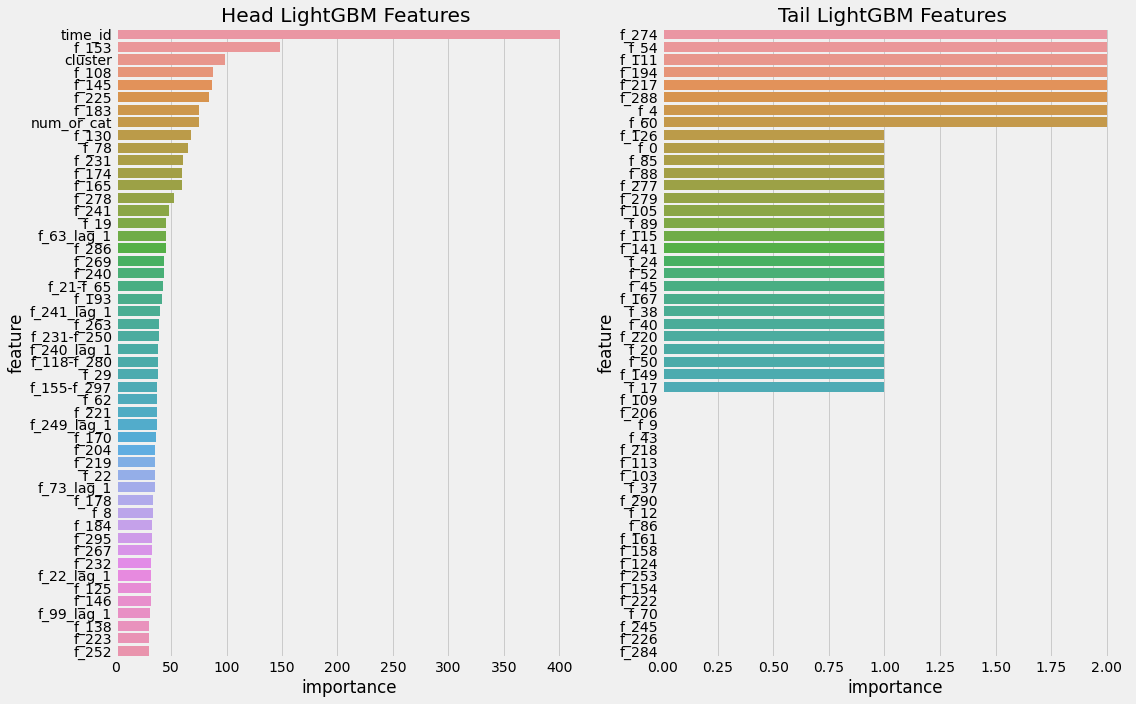

CPU times: user 33min 15s, sys: 49.9 s, total: 34min 4s
Wall time: 4min 51s


In [22]:
%%time

if args.train:
    info = ""
    features_importance, scores = run(info=info)
    df = train[["target", "preds", "time_id"]].query("preds!=-1000")
    score = df.groupby("time_id").apply(lambda x: pearsonr(x.target, x.preds)[0]).mean()
    print(f"lgbm {info} {args.cv_method} {args.folds} folds mean rmse: {rmse(df.target, df.preds):.4f}, mean pearsonr: {pearsonr(df.target, df.preds)[0]:.4f}, mean pearsonr by time_id: {score:.4f}")

    features_importance.to_csv(f"features_importance_{info}.csv", index=False)

    plt.figure(figsize=(16, 10))
    plt.subplot(1,2,1)
    sns.barplot(x="importance", y="feature", data=features_importance.sort_values('importance', ascending=False).head(50))
    plt.title(f'Head LightGBM Features {info}')
    plt.subplot(1,2,2)
    sns.barplot(x="importance", y="feature", data=features_importance.sort_values('importance', ascending=False).tail(50))
    plt.title(f'Tail LightGBM Features {info}')
    plt.tight_layout()
    plt.show()
    del df

# del train
# gc.collect()

### TR with StandardScaler

In [ ]:
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.913214	training's pearsonr: 0.145832	valid_1's rmse: 0.892343	valid_1's pearsonr: 0.131064
# [100]	training's rmse: 0.909675	training's pearsonr: 0.172806	valid_1's rmse: 0.891504	valid_1's pearsonr: 0.133954
# [150]	training's rmse: 0.906853	training's pearsonr: 0.19286	valid_1's rmse: 0.891069	valid_1's pearsonr: 0.135842
# [200]	training's rmse: 0.904353	training's pearsonr: 0.208807	valid_1's rmse: 0.890841	valid_1's pearsonr: 0.136648
# [250]	training's rmse: 0.902257	training's pearsonr: 0.221445	valid_1's rmse: 0.890629	valid_1's pearsonr: 0.13775
# Early stopping, best iteration is:
# [221]	training's rmse: 0.903442	training's pearsonr: 0.21446	valid_1's rmse: 0.890602	valid_1's pearsonr: 0.138316
# lgbm  mean rmse: 0.8906023395143305, mean pearsonr: 0.13831576690093414
# lgbm  single 5 folds mean rmse: 0.8906, mean pearsonr: 0.1383, mean pearsonr by time_id: 0.1368

# Optimize LGBM with Optuna

In [ ]:
import optuna
import warnings
warnings.filterwarnings("ignore", module="lightgbm")
from sklearn.metrics import mean_squared_error

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    # https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302480
    def feval_pearsonr(y_pred, lgb_train):
        y_true = lgb_train.get_label()
        return 'pearsonr', pearsonr(y_true, y_pred)[0], True
    
    time_thresh = round(train.time_id.max() * 0.9)
    trn_ind, val_ind = train.time_id < time_thresh, train.time_id >= time_thresh
    
    X_train, y_train = train.loc[trn_ind, features], train.loc[trn_ind, 'target']
    X_val, y_val = train.loc[val_ind, features], train.loc[val_ind, 'target']
    
    dtrain = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
    dvalid = lgb.Dataset(X_val, y_val, categorical_feature=cat_features)

    param = {
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'objective': 'regression',
        'metric': 'rmse',
        'seed': args.seed,
        'verbosity': 0,
        'boosting_type': 'gbdt', # other options: rf, dart, goss
        'force_col_wise': False, # Use only with CPU devices
       
        'subsample_for_bin': 300000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time
        'n_estimators': trial.suggest_int('n_estimators', 500, 1200),      
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2, 1e-1),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256), # Max number of leaves in one tree
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be 
                                                           # bucketed in. small number of bins may reduce training 
                                                           # accuracy but may deal with overfitting
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0), # Randomly select a subset of features 
                                                                               # if feature_fraction < 1.0
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0), # Randomly select part of data without 
                                                                               # resampling if bagging_fraction < 1.0
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7), # Perform bagging at every k iteration
        'min_data_in_leaf': trial.suggest_int('min_child_samples', 5, 100), # Minimal number of data in one leaf
                                                                            # aliases: min_child_samples, 
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 1e-1), # Stop trying to split 
                                                                                               # leave if sum of it's
                                                                                               # hessian less than k
        'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0), # this can reduce the effect of noises in 
                                                                      # categorical features, especially for 
                                                                      # categories with few data
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'pearsonr', valid_name='valid_1')
    gbm = lgb.train(
        param, 
        train_set = dtrain, 
        valid_sets = [dtrain, dvalid], 
        verbose_eval=100, 
        feval=feval_pearsonr,
        callbacks=[pruning_callback]
    )

    y_pred = gbm.predict(X_val)
    corr = pearsonr(y_val, y_pred)[0]
    return corr


if args.optimize is True:
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize"
    )
    study.optimize(objective, timeout=7*1800)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    
    

# Stacking best LGBM models

### Get best parameters

In [ ]:
if args.train_l2 is True:
    # lgb_params = study.trials_dataframe()
    # lgb_params.to_pickle('LGBM_Optuna_params.pkl')
    lgb_params = pd.read_pickle('LGBM_Optuna_params.pkl').sort_values('value', ascending=False).head(11)

    param_cols = [c for c in lgb_params.columns if c.startswith('params_')]
    lgb_params = lgb_params[param_cols]

    best_params = list()

    for idx, row in lgb_params.iterrows():
        row_dict = {k[7:]: v for k, v in row.items()}
        row_dict['device'] = 'gpu'
        row_dict['gpu_platform_id'] = 0
        row_dict['gpu_device_id'] = 0
        row_dict['verbosity'] = 0
        row_dict['max_bin'] = int(row_dict['max_bin'])
        row_dict['bagging_freq'] = int(row_dict['bagging_freq'])
        row_dict['min_child_samples'] = int(row_dict['min_child_samples'])
        row_dict['n_estimators'] = int(row_dict['n_estimators'])
        row_dict['num_leaves'] = int(row_dict['num_leaves'])
        best_params.append(row_dict)

### Create metafeatures for the train set

In [ ]:
if args.train_l2 is True:
    groups_level2 = [1, 2, 3, 4, 5]

    # That is how we get target for the 2nd level dataset
    y_train_level2 = train.loc[train.group.isin(groups_level2), 'target']

    # Create 1st level feature matrix
    X_train, y_train = train[features], train['target']
    
    # And here we create 2nd level feature matrix, init it with zeros first
    X_train_level2 = np.zeros([y_train_level2.shape[0], len(best_params)+1])
    X_train_level2[:, len(best_params)] = y_train_level2

    meta_index_begin = 0
    meta_index_end = 0

    # Now fill `X_train_level2` with metafeatures
    for current_group in tqdm(groups_level2):
        # split data
        train_index = X_train.loc[train.group <  current_group].index
        test_index  = X_train.loc[train.group == current_group].index

        X_train_l2 = X_train.loc[train_index, :]
        X_test_l2 =  X_train.loc[test_index, :]

        y_train_l2 = y_train[train_index]
        y_test_l2 =  y_train[test_index]

        meta_index_end += y_test_l2.shape[0]

        print(f"===================== time group: {current_group} =====================")
        
        # predict metafeatures for each of LGBM regressors
        for i, params in enumerate(tqdm(best_params)):
            print(f"===================== model: {i} =====================")
            train_dataset = lgb.Dataset(X_train_l2, y_train_l2, categorical_feature=cat_features)
            model = lgb.train(
                params,
                train_set = train_dataset, 
                valid_sets = [train_dataset], 
                verbose_eval=100,
                feval = feval_pearsonr
            )
#             joblib.dump(model, f'lgbr_{i+1}.pkl')
            
            pred = model.predict(X_test_l2)
            X_train_level2[meta_index_begin:meta_index_end, i] = pred

            del train_dataset, model, pred
            gc.collect()

        meta_index_begin = meta_index_end

    X_train_level2 = pd.DataFrame(X_train_level2, columns=[f'lgbr_{i+1}' for i in range(len(best_params))]+['target'])
    X_train_level2.to_pickle('LGBM_X_train_level2.pkl')
    
    # train every LGB model on the full dataset and save it
    for i, params in enumerate(tqdm(best_params)):
        print(f"===================== model: {i} =====================")
        train_dataset = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
        model = lgb.train(
            params,
            train_set = train_dataset, 
            valid_sets = [train_dataset], 
            verbose_eval=100,
            feval = feval_pearsonr
        )
        joblib.dump(model, f'lgbr_{i+1}.pkl')

    del X_train, y_train
    gc.collect()

# Fit LinearRegression for the second layer

In [ ]:
if args.train_l2 is True:
    X_train_level2 = joblib.load('../input/ubiquant-lgbm-models/LGBM_X_train_level2.pkl')

    X = X_train_level2.iloc[:, [i for i in range(5)]]
    y = X_train_level2['target']

    lr = LinearRegression()
    lr.fit(X, y)

    joblib.dump(lr, 'lr.pkl')

# Inference

In [ ]:
import ubiquant

if.args.inference:
    env = ubiquant.make_env()  
    iter_test = env.iter_test()

    lr_model = joblib.load('./lr.pkl')
    lgbr_models = list(map(joblib.load, sorted(Path("../input/ubiquant-lgbm-models").glob("lgbr_*.pkl"))))

    # https://www.kaggle.com/c/ubiquant-market-prediction/discussion/305353 
    # When making predictions check if the investment_id was in the train set
    for (test_df, sample_prediction_df) in iter_test:
        # get feature combinations
        for f in combination_features:
            f1, f2 = f.split("-")
            test_df[f] = test_df[f1] + test_df[f2]

    #     test_df["time_id"] = test_df.row_id.str.split("_", expand=True)[1].astype(np.uint16) # extract time_id from row_id
        unqiues = len(test_df['f_7'].unique())
        if unqiues/len(test_df) > 0.5:
            test_df['num_or_cat'] = 0
        else:
            test_df['num_or_cat'] = 1

        test_df["preds"] = lr_model.predict(np.stack([model.predict(test_df[features_backup]) for model in lgbr_models[:5]], axis=1))
        sample_prediction_df['target'] = test_df["preds"]
        env.predict(sample_prediction_df) 
        display(sample_prediction_df)

# Further ideas

- very useful techiques https://www.kaggle.com/beatwad/ubiquant-rapids-random-forest-svm/edit
- feature neutralization (https://www.kaggle.com/code1110/janestreet-avoid-overfit-feature-neutralization?scriptVersionId=53012639)
- feature selection techniques
- f_259 is target_lag_2


- LGBM Imputation


- try custom loss function (for DNN) (https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302181)

# What works for LGBM CV

- define if feature is numerical of categorical at this time period (num_or_cat)
- clipping of target (at 0.5% min/max)